In [3]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
from EMG_gestures.utils import *

In [ ]:
#comparing: within-subject naive, joint-training, transform module

#held out subjects, Kfold CV used to optimize hyperparams + archs
#naive: train on all others - report on test
#joint-training: train on all others, test on held-out
#transform module: train feature extractor on all others, test on held-out (half of data used for transform module)

#DANN - train on all others, use DANN to adapt



In [6]:
#randomly-selected subjects to use as hold-out test data 
test_subjects = [10, 12, 20, 14, 23, 34]

In [27]:
# Load within-subject data for held-out subjects
# Load logistic regression within-subject data


within_results_df = [] 

results_folder = '../results_data/single_subject_training/simple_NN'
for src_subject_id in test_subjects:
    results_fn = 'subject_%02d_within_subject_results.h5'%(src_subject_id)
    subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    subject_df['Train_Subject'] = subject_df['Subject']
    subject_df['Test_Subject'] = subject_df['Subject']
    subject_df = subject_df.drop(columns = ['Subject'])
    within_results_df.append(subject_df)

within_results_df = pd.concat(within_results_df,axis = 0)

# Average over multiple train/test splits of the data
within_results_df = within_results_df.groupby(['Shuffled','Type','Train_Subject','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Rep','Epochs','Batch_Size','Train_Loss','Val_Loss'])

# Output summary
display(HTML(within_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Train_Subject','Test_Subject']).to_html()))

In [14]:
# Load naive generalization test data for held-out subjects
results_folder = '../results_data/single_subject_training/simple_NN'
naive_results_df = [] 
for src_subject_id in test_subjects:
    results_fn = 'subject_%02d_across_subject_results.h5'%(src_subject_id)
    subject_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    #select data relevant for 
    subject_df = subject_df.loc[subject_df.Test_Subject.isin(test_subjects)]
    naive_results_df.append(subject_df)

naive_results_df = pd.concat(naive_results_df,axis = 0)

# Average over train subjects
naive_results_df = naive_results_df.groupby(['Shuffled','Type','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Train_Subject','Rep','Epochs','Batch_Size','Train_Loss','Val_Loss'])

# Output summary
display(HTML(naive_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Test_Subject']).to_html()))


In [24]:
# Load joint training data
results_folder = '../results_data/xsubject_joint_data/simple_NN'
results_fn = 'nn_joint_testing_results.h5'
joint_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
joint_results_df['Type'] = 'Test'
joint_results_df = joint_results_df.groupby(['Shuffled','Type','Test_Subject'],as_index = False)\
.mean()\
.drop(columns = ['Rep'])
# Output summary
display(HTML(joint_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Test_Subject']).to_html()))


,,f1_score,accuracy_score
Shuffled,Type,,
False,Test,0.843134,0.857605
True,Test,0.173404,0.180369


In [28]:
#combine multiple dataframes

# keep test scores only
within_results_df = within_results_df.loc[within_results_df.Type=='Test']
naive_results_df = naive_results_df.loc[naive_results_df.Type=='Test']
joint_results_df = joint_results_df.loc[joint_results_df.Type=='Test']
#drop test subject column
within_results_df = within_results_df.drop(columns = ['Train_Subject'])
# label
within_results_df['Test_Type'] = 'Within_Subject'
naive_results_df['Test_Type'] = 'Naive_xSubject'
joint_results_df['Test_Type'] = 'Joint_Training'
#combine
all_results_df = pd.concat([within_results_df, naive_results_df, joint_results_df],axis = 0)


In [29]:
score2use = 'f1_score'
exp_conditions = ['Within_Subject', 'Naive_xSubject', 'Joint_Training']

shuffle_df = all_results_df.loc[all_results_df.Shuffled == True]
true_df = all_results_df.loc[all_results_df.Shuffled == False]

# Get confidence interval for shuffled data results
null_ci = np.zeros((len(exp_conditions),2))

for j,t in enumerate(exp_conditions):
    null_df = shuffle_df.loc[shuffle_df.Test_Type == t]
    null_ci[j,:] = sns.utils.ci(sns.algorithms.bootstrap(null_df[score2use].values))


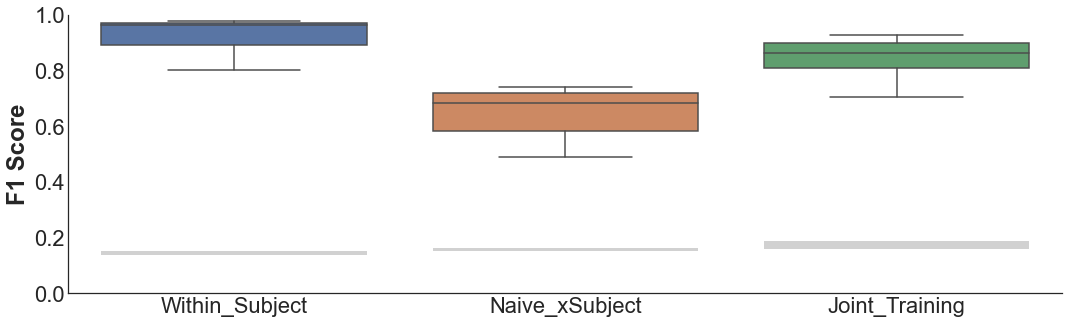

In [31]:

#make plot
g = sns.catplot(data = true_df, x= 'Test_Type', y = score2use,\
            order = exp_conditions, kind = 'box', aspect = 3)

# #Label axes and subpots, mark chance confidence interval
for i,ax in enumerate(g.axes[0]):
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    ax.set_xticklabels(exp_conditions,horizontalalignment = 'center')
    ax.set_ylabel('F1 Score')
    for j,t in enumerate(exp_conditions):
        ax.add_patch(patches.Rectangle(((1*j)-.4, null_ci[j,0]), .8, (null_ci[j,1]-null_ci[j,0]),\
                                             linewidth=0, fill=True, color='k', alpha=0.2))

sns.despine(fig=g.fig, bottom = False)

In [32]:
ax.get_xticks()

array([0, 1])